In [1]:
# IMPORTS

# Modules
import numpy as np
import pandas as pd
import csv
import cv2
import pickle
import matplotlib.pyplot as plt
import os
import math

# Utilities
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from random import randint, random

# Deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU
from keras.layers import Conv2D
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.regularizers import l2

# Plot in the notebook
%matplotlib inline

Using TensorFlow backend.


In [48]:
# CONSTANTS
DATA_DIR = 'data/'
DATA_FILE = 'driving_log.csv'

BATCH_SIZE = 16

# Resizing constants
NEW_WIDTH = 64
NEW_HEIGHT = 64
TOP_STRIDE_TO_CROP = 30
BOTTOM_STRIDE_TO_CROP = 25

# augmentation constants
ANGLE_TRESHOLD = 0.1

In [49]:
# Load CSV file
csv_file = []
with open(DATA_DIR+'/'+DATA_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_file.append(line)

In [50]:
# Split csv in train and validation sets
csv_train, csv_valid = train_test_split(csv_file, test_size = 0.3)

#### Funtion definitions for processing images

In [51]:
# Get sample image for testing
sample_idx = np.random.choice(len(csv_file))
path = DATA_DIR + csv_file[sample_idx][0].strip()
sample_image = cv2.imread(path)
sample_angle = csv_file[sample_idx][3]

In [52]:
# Image transformations
# Transformation list:
tr_list = [iaa.Add((-75, 75)), # change brightness of images (by -10 to 10 of original value)
           iaa.Multiply((0.5, 2.0)),
           iaa.ContrastNormalization((0.5, 2.0)), # improve or worsen the contrast
           iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
           iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))]
seq = iaa.SomeOf((0, 2), tr_list)

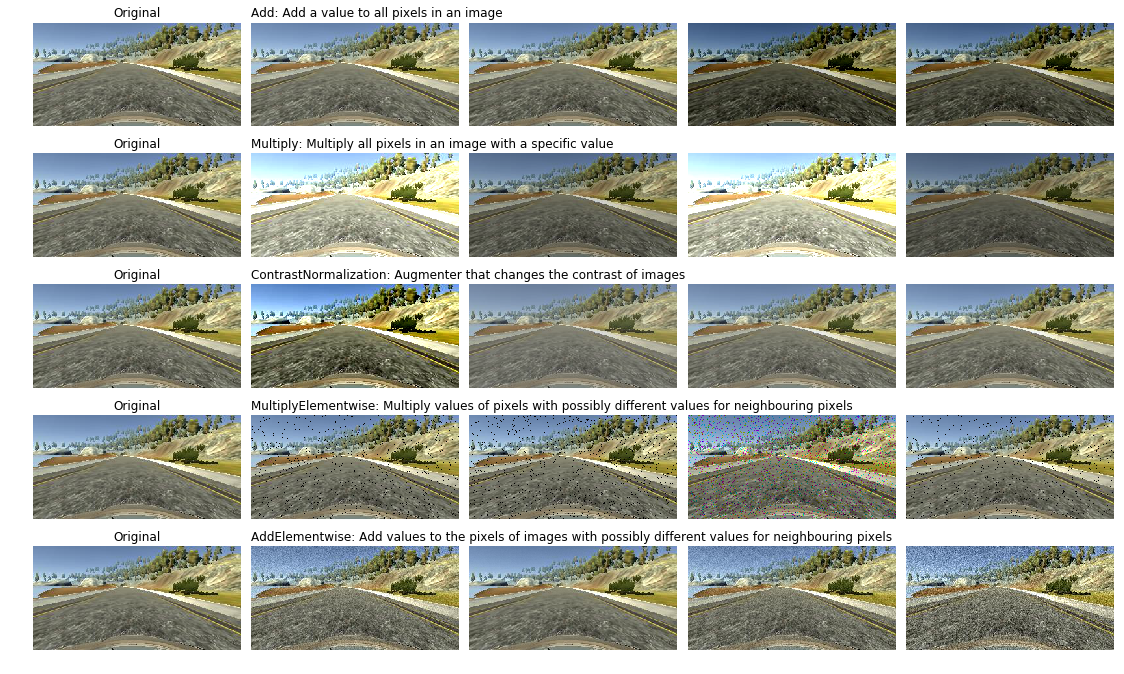

In [53]:
### Test image transformations
# Graph paramters
plot_width, plot_height = 15, 9
grid_rows, grid_cols = 5, 5
sample_size = grid_rows * grid_cols 

# Plot 
fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for tr_fn in tr_list:
    # Print non-transformed image
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    imgplt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original')
    counter += 1
    # Print transformed images
    tr_images = tr_fn.augment_images([sample_image]*(grid_cols-1))
    print_title = True
    for tr_image in tr_images:
        imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
        imgplt.imshow(cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB))
        imgplt.axis('off')
        if print_title:
            imgplt.set_title('{}: {}'.format(tr_fn.name[7:],' '.join(tr_fn.__doc__.split('.')[0].split())), loc='left')
            print_title = False
        counter += 1

(-0.5, 63.5, 63.5, -0.5)

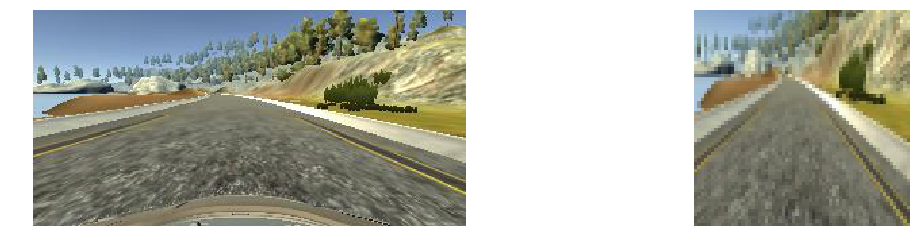

In [55]:
# Image resizing
def resize_fn(image,
              top_stride = TOP_STRIDE_TO_CROP, bottom_stride = BOTTOM_STRIDE_TO_CROP,
              new_height = NEW_HEIGHT, new_width = NEW_WIDTH):
    """
    Crop top and bottom strides and resize to certain height and width
    """
    height = image.shape[0]
    image = image[top_stride:height-bottom_stride, :, :]
    image = cv2.resize(image,(new_height, new_width), interpolation=cv2.INTER_AREA)
    return image

# Test resizing in sample image
fig = plt.figure(figsize = (15, 3))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
imgplt = fig.add_subplot(1, 2, 1)
imgplt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
imgplt.axis('off')
imgplt = fig.add_subplot(1, 2, 2)
imgplt.imshow(cv2.cvtColor(resize_fn(sample_image), cv2.COLOR_BGR2RGB))
imgplt.axis('off')

#### Generator definition

In [56]:
def transformed_data_generator(csv_file, resize = False, batch_size = BATCH_SIZE):
    
    if resize:
        size = (batch_size, 64, 64, 3)
    else:    
        size = (batch_size, 160, 320, 3)    
    batch_train = np.zeros(size, dtype = np.uint8)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        for idx in range(batch_size):
            # Get random csv line
            while True:
                line_idx = np.random.choice(len(csv_file))
                angle = float(csv_file[line_idx][3])
                # If angle above treshold get it
                if angle > ANGLE_TRESHOLD:
                    break
                # if below, discard with 0.5 prob
                elif random() > 0.5:
                    break   
            
            ### Randomly choose center, left or right image
            # Get random camera 0:center, 1:left, 2:right 
            camera_idx = np.random.choice(3)
            # Load image
            path = DATA_DIR + csv_file[line_idx][camera_idx].strip()
            image = cv2.imread(path)
            if resize:
                batch_train[idx] = resize_fn(image)
            else:
                batch_train[idx] = image
            # Adjust angle
            shift_angle = [0, 0.25, -0.25][camera_idx]
            batch_angle[idx] = angle + shift_angle
            
            ### Randomly flip
            # If flip image with 0.5 prob
            if random() > 0.5:
                batch_train[idx] = cv2.flip(batch_train[idx],1)
                batch_angle[idx] *= -1
        
        ### Random image transformation
        # up to two of the following transformations:
        # Bright augmentation
        # Multiply
        # Contrast normalization
        # Dropout ()
        # Additive Gaussian Noise
        batch_train = seq.augment_images(batch_train)
            
        yield batch_train, batch_angle

In [57]:
def original_data_generator(csv_file, resize = False, batch_size = BATCH_SIZE):
    
    if resize:
        size = (batch_size, 64, 64, 3)
    else:    
        size = (batch_size, 160, 320, 3)
    batch_train = np.zeros(size, dtype = np.uint8)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        for idx in range(batch_size):
            line_idx = np.random.choice(len(csv_file))
            path = DATA_DIR + csv_file[line_idx][0].strip()
            image = cv2.imread(path)
            if resize:
                batch_train[idx] = resize_fn(image)
            else:
                batch_train[idx] = image
            batch_angle[idx] = float(csv_file[line_idx][3])          
            
        yield batch_train, batch_angle

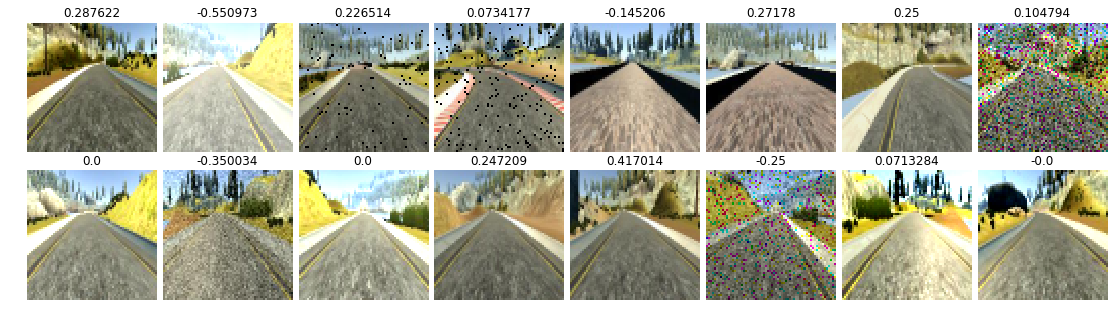

In [58]:
### Test data generators
for tr_images, tr_angles in transformed_data_generator(csv_train, resize = True):
    break

for or_images, or_angles in original_data_generator(csv_valid, resize = True):
    break
    
sample_size = 16
plot_width, plot_height = 15, 4
grid_rows, grid_cols = 2, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(tr_images, tr_angles):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title(angle)

(1616,)


(array([   9.,   38.,  121.,  488.,  453.,  396.,   92.,   18.,    0.,    1.]),
 array([-0.87941867, -0.67315299, -0.46688731, -0.26062163, -0.05435594,
         0.15190974,  0.35817542,  0.5644411 ,  0.77070678,  0.97697247,
         1.18323815]),
 <a list of 10 Patch objects>)

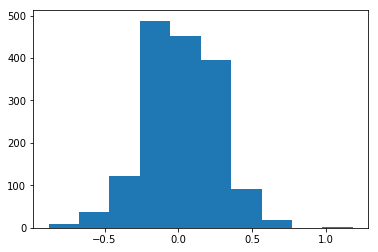

In [72]:
tr_angles = []
counter = 0
sample_size = 100
for images, angles in transformed_data_generator(csv_train):
    counter += 1
    tr_angles = np.concatenate((tr_angles, angles))
    if counter > sample_size: break
print(tr_angles.shape)

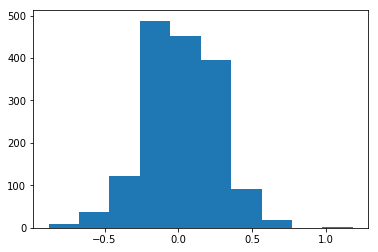

In [73]:
hist = plt.hist(tr_angles)

Histograms of original data versus transformed data.

In [59]:
train_data_generator = transformed_data_generator(csv_train, resize = True)
valid_data_generator = original_data_generator(csv_valid, resize = True)

In [62]:
# Training Architecture: inspired by NVIDIA architecture #
input_shape = (64,64,3)

model = Sequential()

model.add(Lambda(lambda x: x/255 - 0.5, input_shape = input_shape))

model.add(Conv2D(24, (5, 5), padding = 'valid', strides = (2, 2),
                 kernel_initializer = 'random_uniform', bias_initializer = 'zeros',
                 kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001),
                 activation = 'relu'))

model.add(Conv2D(36, (5, 5), padding = 'valid', strides = (2, 2),
                 kernel_initializer = 'random_uniform', bias_initializer = 'zeros',
                 kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001),
                 activation = 'relu'))

model.add(Conv2D(48, (5, 5), padding = 'valid', strides = (2, 2),
                 kernel_initializer = 'random_uniform', bias_initializer = 'zeros',
                 kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001),
                 activation = 'relu'))

model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2),
                 kernel_initializer = 'random_uniform', bias_initializer = 'zeros',
                 kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001),
                 activation = 'relu'))

model.add(Conv2D(64, (3, 3), padding = 'valid', strides = (2, 2),
                 kernel_initializer = 'random_uniform', bias_initializer = 'zeros',
                 kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001),
                 activation = 'relu'))

model.add(Flatten())

model.add(Dense(80, kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(40, kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(16, kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(10, kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))

model.add(Dense(1, kernel_regularizer = l2(0.001), bias_regularizer = l2(0.001)))

model.compile(optimizer= Adam(), loss='mse', metrics=['accuracy'])

model.summary()

model.fit_generator(train_data_generator, steps_per_epoch = len(csv_train)/BATCH_SIZE,
                    nb_epoch=5, #FLAGS.epochs,
                    validation_data = valid_data_generator, validation_steps = len(csv_valid)/BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 30, 30, 24)        1824      
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 13, 13, 36)        21636     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 5, 5, 48)          43248     
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 3, 3, 64)          27712     
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
__________

//anaconda/envs/sdc/lib/python3.5/site-packages/ipykernel/__main__.py:54: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
//anaconda/envs/sdc/lib/python3.5/site-packages/ipykernel/__main__.py:54: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=5625, validation_data=<generator..., steps=2411, epochs=5)`


TypeError: fit_generator() got an unexpected keyword argument 'steps'